In [1]:
from time import time

import pandas as pd
import pygmo as pg

from spineq.data.census import PopulationDataset, WorkplaceDataset
from spineq.data.group import LocalAuthority
from spineq.mappings import lad20nm_to_lad20cd
from spineq.opt.coverage import ExponentialCoverage
from spineq.opt.objectives import Column, CombinedObjectives
from spineq.opt.pygmo import PyGMO
from spineq.plot.plotting import plot_optimisation_result

/Users/jroberts/opt/anaconda3/envs/spatial-inequality/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
lad20nm = "Newcastle upon Tyne"
lad20cd = lad20nm_to_lad20cd(lad20nm)

n_sensors = 20
theta = 500

child_age = 16
elder_age = 65

pop_total_weight = 1
pop_child_weight = 0
pop_elder_weight = 0
work_weight = 0

## Create coverage objective

In [3]:
total = PopulationDataset(lad20cd).to_total()
child = (
    PopulationDataset(lad20cd).filter_age(high=child_age, name="children").to_total()
)
elder = PopulationDataset(lad20cd).filter_age(low=elder_age, name="elderly").to_total()
work = WorkplaceDataset(lad20cd)
la = LocalAuthority(lad20cd, datasets=[total, child, elder, work])

cov = ExponentialCoverage.from_la(la, theta)

objs = CombinedObjectives(
    la,
    [
        Column(total.name, "total", pop_total_weight),
        Column(child.name, "total", pop_child_weight),
        Column(elder.name, "total", pop_elder_weight),
        Column(work.name, "workers", work_weight),
    ],
    cov,
)

## Run Optimisation

In [4]:
algo = pg.gaco(gen=100)
population_size = 100

opt = PyGMO(algo, population_size)
result = opt.run(objs, n_sensors)
plot_optimisation_result(result.best_result)

## Compare Algorithms

In [14]:
algorithms = [
    {"name": "Extended Ant Colony Optimization (GACO)", "fn": pg.gaco},
    {"name": "Differential Evolution (DE)", "fn": pg.de},
    {"name": "Self-adaptive DE (jDE and iDE)", "fn": pg.sade},
    {"name": "Self-adaptive DE (de_1220 aka pDE)", "fn": pg.de1220},
    {"name": "Grey wolf optimizer (GWO)", "fn": pg.gwo},
    {"name": "Improved Harmony Search", "fn": pg.ihs},
    {"name": "Particle Swarm Optimization (PSO)", "fn": pg.pso},
    {"name": "Particle Swarm Optimization Generational (GPSO)", "fn": pg.pso_gen},
    {"name": "(N+1)-ES Simple Evolutionary Algorithm", "fn": pg.sea},
    {"name": "Simple Genetic Algorithm", "fn": pg.sga},
    {"name": "Corana’s Simulated Annealing (SA)", "fn": pg.simulated_annealing},
    {"name": "Artificial Bee Colony (ABC)", "fn": pg.bee_colony},
    {"name": "Covariance Matrix Adaptation Evo. Strategy (CMA-ES)", "fn": pg.cmaes},
    {"name": "Exponential Evolution Strategies (xNES)", "fn": pg.xnes},
]

In [15]:
def run_opt(objs, uda, gen=100, size=100):
    start_time = time()

    opt = PyGMO(algo, population_size, verbosity=0)
    result = opt.run(objs, n_sensors)

    elapsed = time() - start_time

    return result.best_coverage, elapsed

In [16]:
for i, alg in enumerate(algorithms):
    print("Doing", alg["name"])
    try:
        score, elapsed = run_opt(objs, alg["fn"])
        algorithms[i]["score"] = score
        algorithms[i]["time"] = elapsed
        print("Score:", score)
        print("Time:", elapsed)
    except Exception as e:
        print(f"Error {e}")

    print("-" * 30)

Doing Extended Ant Colony Optimization (GACO)
Score: 0.30097385783901814
Time: 21.411389112472534
------------------------------
Doing Differential Evolution (DE)
Score: 0.30551045556346046
Time: 21.80218505859375
------------------------------
Doing Self-adaptive DE (jDE and iDE)
Score: 0.2994170890160799
Time: 20.536516904830933
------------------------------
Doing Self-adaptive DE (de_1220 aka pDE)
Score: 0.3045214597981208
Time: 20.774012088775635
------------------------------
Doing Grey wolf optimizer (GWO)
Score: 0.3006671527772497
Time: 22.2520809173584
------------------------------
Doing Improved Harmony Search
Score: 0.2981932447560657
Time: 21.100879192352295
------------------------------
Doing Particle Swarm Optimization (PSO)
Score: 0.29735970307083637
Time: 20.999377250671387
------------------------------
Doing Particle Swarm Optimization Generational (GPSO)
Score: 0.2992956622319708
Time: 20.30958914756775
------------------------------
Doing (N+1)-ES Simple Evolution

In [17]:
df = pd.DataFrame(algorithms)

print("BEST SCORE:")
display(df.sort_values(by="score", ascending=False).head())

print("FASTEST:")
display(df.sort_values(by="time", ascending=True).head())

BEST SCORE:


,name,fn,score,time
1,Differential Evolution (DE),<class 'pygmo.core.de'>,0.305510,21.802185
3,Self-adaptive DE (de_1220 aka pDE),<class 'pygmo.core.de1220'>,0.304521,20.774012
9,Simple Genetic Algorithm,<class 'pygmo.core.sga'>,0.301853,20.253228
8,(N+1)-ES Simple Evolutionary Algorithm,<class 'pygmo.core.sea'>,0.301757,23.641314
13,Exponential Evolution Strategies (xNES),<class 'pygmo.core.xnes'>,0.301088,19.816713


FASTEST:


,name,fn,score,time
13,Exponential Evolution Strategies (xNES),<class 'pygmo.core.xnes'>,0.301088,19.816713
9,Simple Genetic Algorithm,<class 'pygmo.core.sga'>,0.301853,20.253228
7,Particle Swarm Optimization Generational (GPSO),<class 'pygmo.core.pso_gen'>,0.299296,20.309589
2,Self-adaptive DE (jDE and iDE),<class 'pygmo.core.sade'>,0.299417,20.536517
3,Self-adaptive DE (de_1220 aka pDE),<class 'pygmo.core.de1220'>,0.304521,20.774012


## Simple Genetic Algorithm

Best coverage 0.34459622757997455


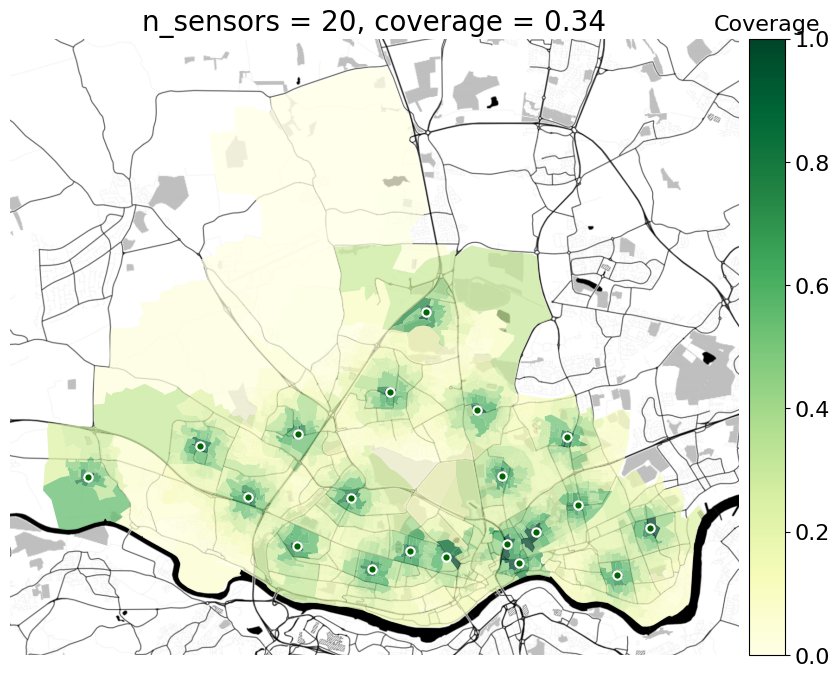

In [20]:
algo = pg.sga(gen=200)
opt = PyGMO(algo, population_size=200, verbosity=0)
result = opt.run(objs, n_sensors)

print("Best coverage", result.best_coverage)
plot_optimisation_result(result.best_result)

## Simple Evolutionary Algorithm

Best coverage 0.34442774288638284


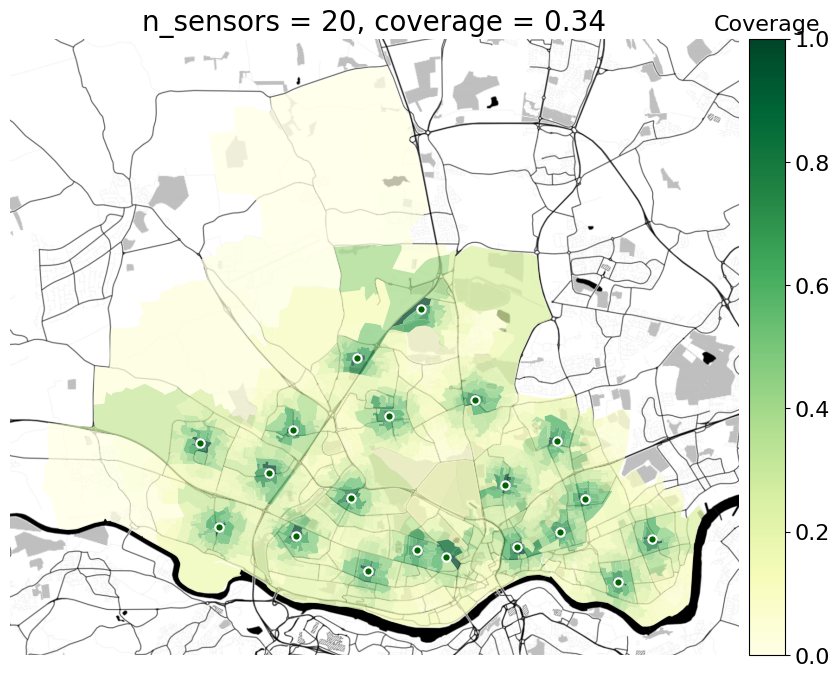

In [22]:
algo = pg.sea(gen=20000)
opt = PyGMO(algo, population_size=1000, verbosity=0)
result = opt.run(objs, n_sensors)

print("Best coverage", result.best_coverage)
plot_optimisation_result(result.best_result)